In [2]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from scipy.special import jn
import seaborn as sns
import pylab as pl
import matplotlib.pyplot as plt
from IPython.display import display,clear_output,Image
import re  ## 
import csv ## 
import time
import datetime
from datetime import datetime as dt
from math import isnan
import warnings
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y/%m/%d ')

%matplotlib inline

from sklearn import tree
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score,confusion_matrix,r2_score

warnings.filterwarnings('ignore')

# Data Preparation

In [84]:
df_old = pd.read_excel(r'../data/old_data117.xlsx')
df_new = pd.read_excel(r'../data/new_data67.xlsx')

df_old_2 = df_old.drop(columns=['Pre_Serumtrough_value'])
df_new_2 = df_new.drop(columns=['Pre_Serumtrough_value'])
import math
df_old_2['Therapeutic_dose'] = df_old_2['Therapeutic_dose'].apply(lambda x: math.log(x))
df_new_2['Therapeutic_dose'] = df_new_2['Therapeutic_dose'].apply(lambda x: math.log(x))
df_old_2['Last_therapeutic_dose'] = df_old_2['Last_therapeutic_dose'].apply(lambda x: math.log(x) if x>0 else 0)   # log取得时候， x不能取到0
df_new_2['Last_therapeutic_dose'] = df_new_2['Last_therapeutic_dose'].apply(lambda x: math.log(x) if x>0 else 0)   # log取得时候， x不能取到0

# Data Statistics

In [387]:
df_info = pd.concat([df_old,df_new],axis=0)
df_info = df_info.reset_index()
del df_info['index']

In [388]:
for i in df_info.columns:
    print(df_info[i].describe(),'\n')

count          184
unique         152
top       70060086
freq             4
Name: patient_id, dtype: int64 

count    184.000000
mean      65.847826
std       15.463643
min       24.000000
25%       57.250000
50%       68.000000
75%       76.000000
max       97.000000
Name: Age, dtype: float64 

count    184.000000
mean       0.364130
std        0.482498
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Gender, dtype: float64 

count    154.000000
mean      63.367208
std       13.084766
min       35.000000
25%       55.000000
50%       62.500000
75%       70.000000
max      174.000000
Name: Weight, dtype: float64 

count     184.000000
mean     1734.575569
std       710.892755
min       250.000000
25%      1000.000000
50%      2000.000000
75%      2000.000000
max      3428.571429
Name: Therapeutic_dose, dtype: float64 

count     184.000000
mean      660.597826
std       886.393301
min         0.000000
25%         0.000000
50%    

In [89]:
for i in df_info.columns:
    x = df_info[i].isnull().sum()
    if x>0:
        print(i,x,' ','%.1f%%'%(x/df_info.shape[0]*100))


Weight 30   16.3%
UA 8   4.3%
SCr 7   3.8%
PCT 41   22.3%
CRP 38   20.7%
ALT 11   6.0%
AST 11   6.0%
TBIL 11   6.0%
DBIL 11   6.0%
TP 11   6.0%
RBC 10   5.4%
WBC 7   3.8%
Hb 1   0.5%


# Model

In [93]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb
# import catboost as ctb

In [94]:
from sklearn.model_selection import train_test_split
x_old = df_old_2.iloc[:,1:]
y_old = df_old_2['Therapeutic_dose']
tran_x_old,test_x_old,tran_y_old,test_y_old=train_test_split(x_old,y_old,test_size=0.3,random_state = 60)
x_new = df_new_2.iloc[:,1:]
y_new = df_new_2['Therapeutic_dose']
tran_x_new,test_x_new,tran_y_new,test_y_new=train_test_split(x_new,y_new,test_size=0.3,random_state = 60)

tran_x_new.index += 1000
test_x_new.index += 1000
tran_y_new.index += 1000
test_y_new.index += 1000
# 训练集
tran_x = pd.concat([tran_x_old,tran_x_new],axis=0)
tran_y = pd.concat([tran_y_old,tran_y_new],axis=0)
# 测试集
test_x = pd.concat([test_x_old,test_x_new],axis=0)
test_y = pd.concat([test_y_old,test_y_new],axis=0)
# ===========================================  Model =========================================== 
from auto_ml import Predictor
from auto_ml.utils import get_boston_dataset

column_descriptions = {
    'Therapeutic_dose': 'output' 
}
ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)

ml_predictor.train(tran_x, model_names=['XGBRegressor'])

test_score = ml_predictor.score(test_x, test_x['Therapeutic_dose'])
file_name = ml_predictor.save()
trained_model = load_ml_model(file_name)

predictions = ml_predictor.predict(test_x)

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}
Running basic data cleaning
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


********************************************************************************************
About to fit the pipeline for the model XGBRegressor to predict Therapeutic_dose
Started at:
2021-03-29 15:52:47
[15:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg

In [116]:
im_auto = pd.DataFrame(data={'Variable Name':list(trained_model.feature_importances_.keys()),
                             'Importance Score':list(trained_model.feature_importances_.values())})
im_auto = im_auto.sort_values(by='Importance Score',ascending=False)
im_auto = im_auto.reset_index()
del im_auto['index']

im_auto = im_auto.loc[0:9,:]
im_auto

,Variable Name,Importance Score
0,SCr,0.114752
1,Last_therapeutic_dose,0.111167
2,Serumtrough value,0.101813
3,RBC,0.061394
4,Age,0.051877
5,Weight,0.049275
6,Fluconazole,0.048685
7,Gender,0.042594
8,CRP,0.040297
9,WBC,0.036834


In [118]:
x_old = df_old_2.iloc[:,1:]
y_old = df_old_2['Therapeutic_dose']
tran_x_old,test_x_old,tran_y_old,test_y_old=train_test_split(x_old.drop(columns=['Therapeutic_dose']),y_old,test_size=0.3,random_state = 60)
x_new = df_new_2.iloc[:,1:]
y_new = df_new_2['Therapeutic_dose']
tran_x_new,test_x_new,tran_y_new,test_y_new=train_test_split(x_new.drop(columns=['Therapeutic_dose']),y_new,test_size=0.3,random_state = 60)

tran_x_new.index += 1000
test_x_new.index += 1000
tran_y_new.index += 1000
test_y_new.index += 1000
# Train Data
tran_x = pd.concat([tran_x_old,tran_x_new],axis=0)
tran_y = pd.concat([tran_y_old,tran_y_new],axis=0)
# Test Data
test_x = pd.concat([test_x_old,test_x_new],axis=0)
test_y = pd.concat([test_y_old,test_y_new],axis=0)
#============================= model ==================================
trained_model = load_ml_model(file_name)
params = trained_model.named_steps['final_model'].model.get_params()

model = xgb.XGBRegressor(**params)
eval_set = [(test_x, test_y)]
clt = model.fit(tran_x,tran_y,early_stopping_rounds=50,eval_set=eval_set,verbose=False)
y_pred = clt.predict(test_x)

[16:37:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [119]:
print('R2:  ',r2_score(test_y,y_pred,multioutput='variance_weighted'))
print('MSE: ',mean_squared_error(test_y,y_pred))
print('RMSE:',mean_squared_error(test_y,y_pred) ** 0.5)
print('MAE: ',mean_absolute_error(test_y,y_pred))

R2:   0.7316746151482905
MSE:  0.057160972475305265
RMSE: 0.23908360980064122
MAE:  0.1932519162692619


# SHAP（Single factor  Top20）

In [127]:
import shap
explainer = shap.TreeExplainer(model)

# shap value
shap_values = explainer.shap_values(tran_x)

# Baseline of Model ybase     (Typically the mean of the target variable across all samples)
y_base = explainer.expected_value
print(y_base)
y_pred_1 = model.predict(tran_x)  
print(y_pred_1.mean())


7.330238
7.33024


In [128]:
print(shap_values.shape)
print(tran_x.shape)

(127, 25)
(127, 25)


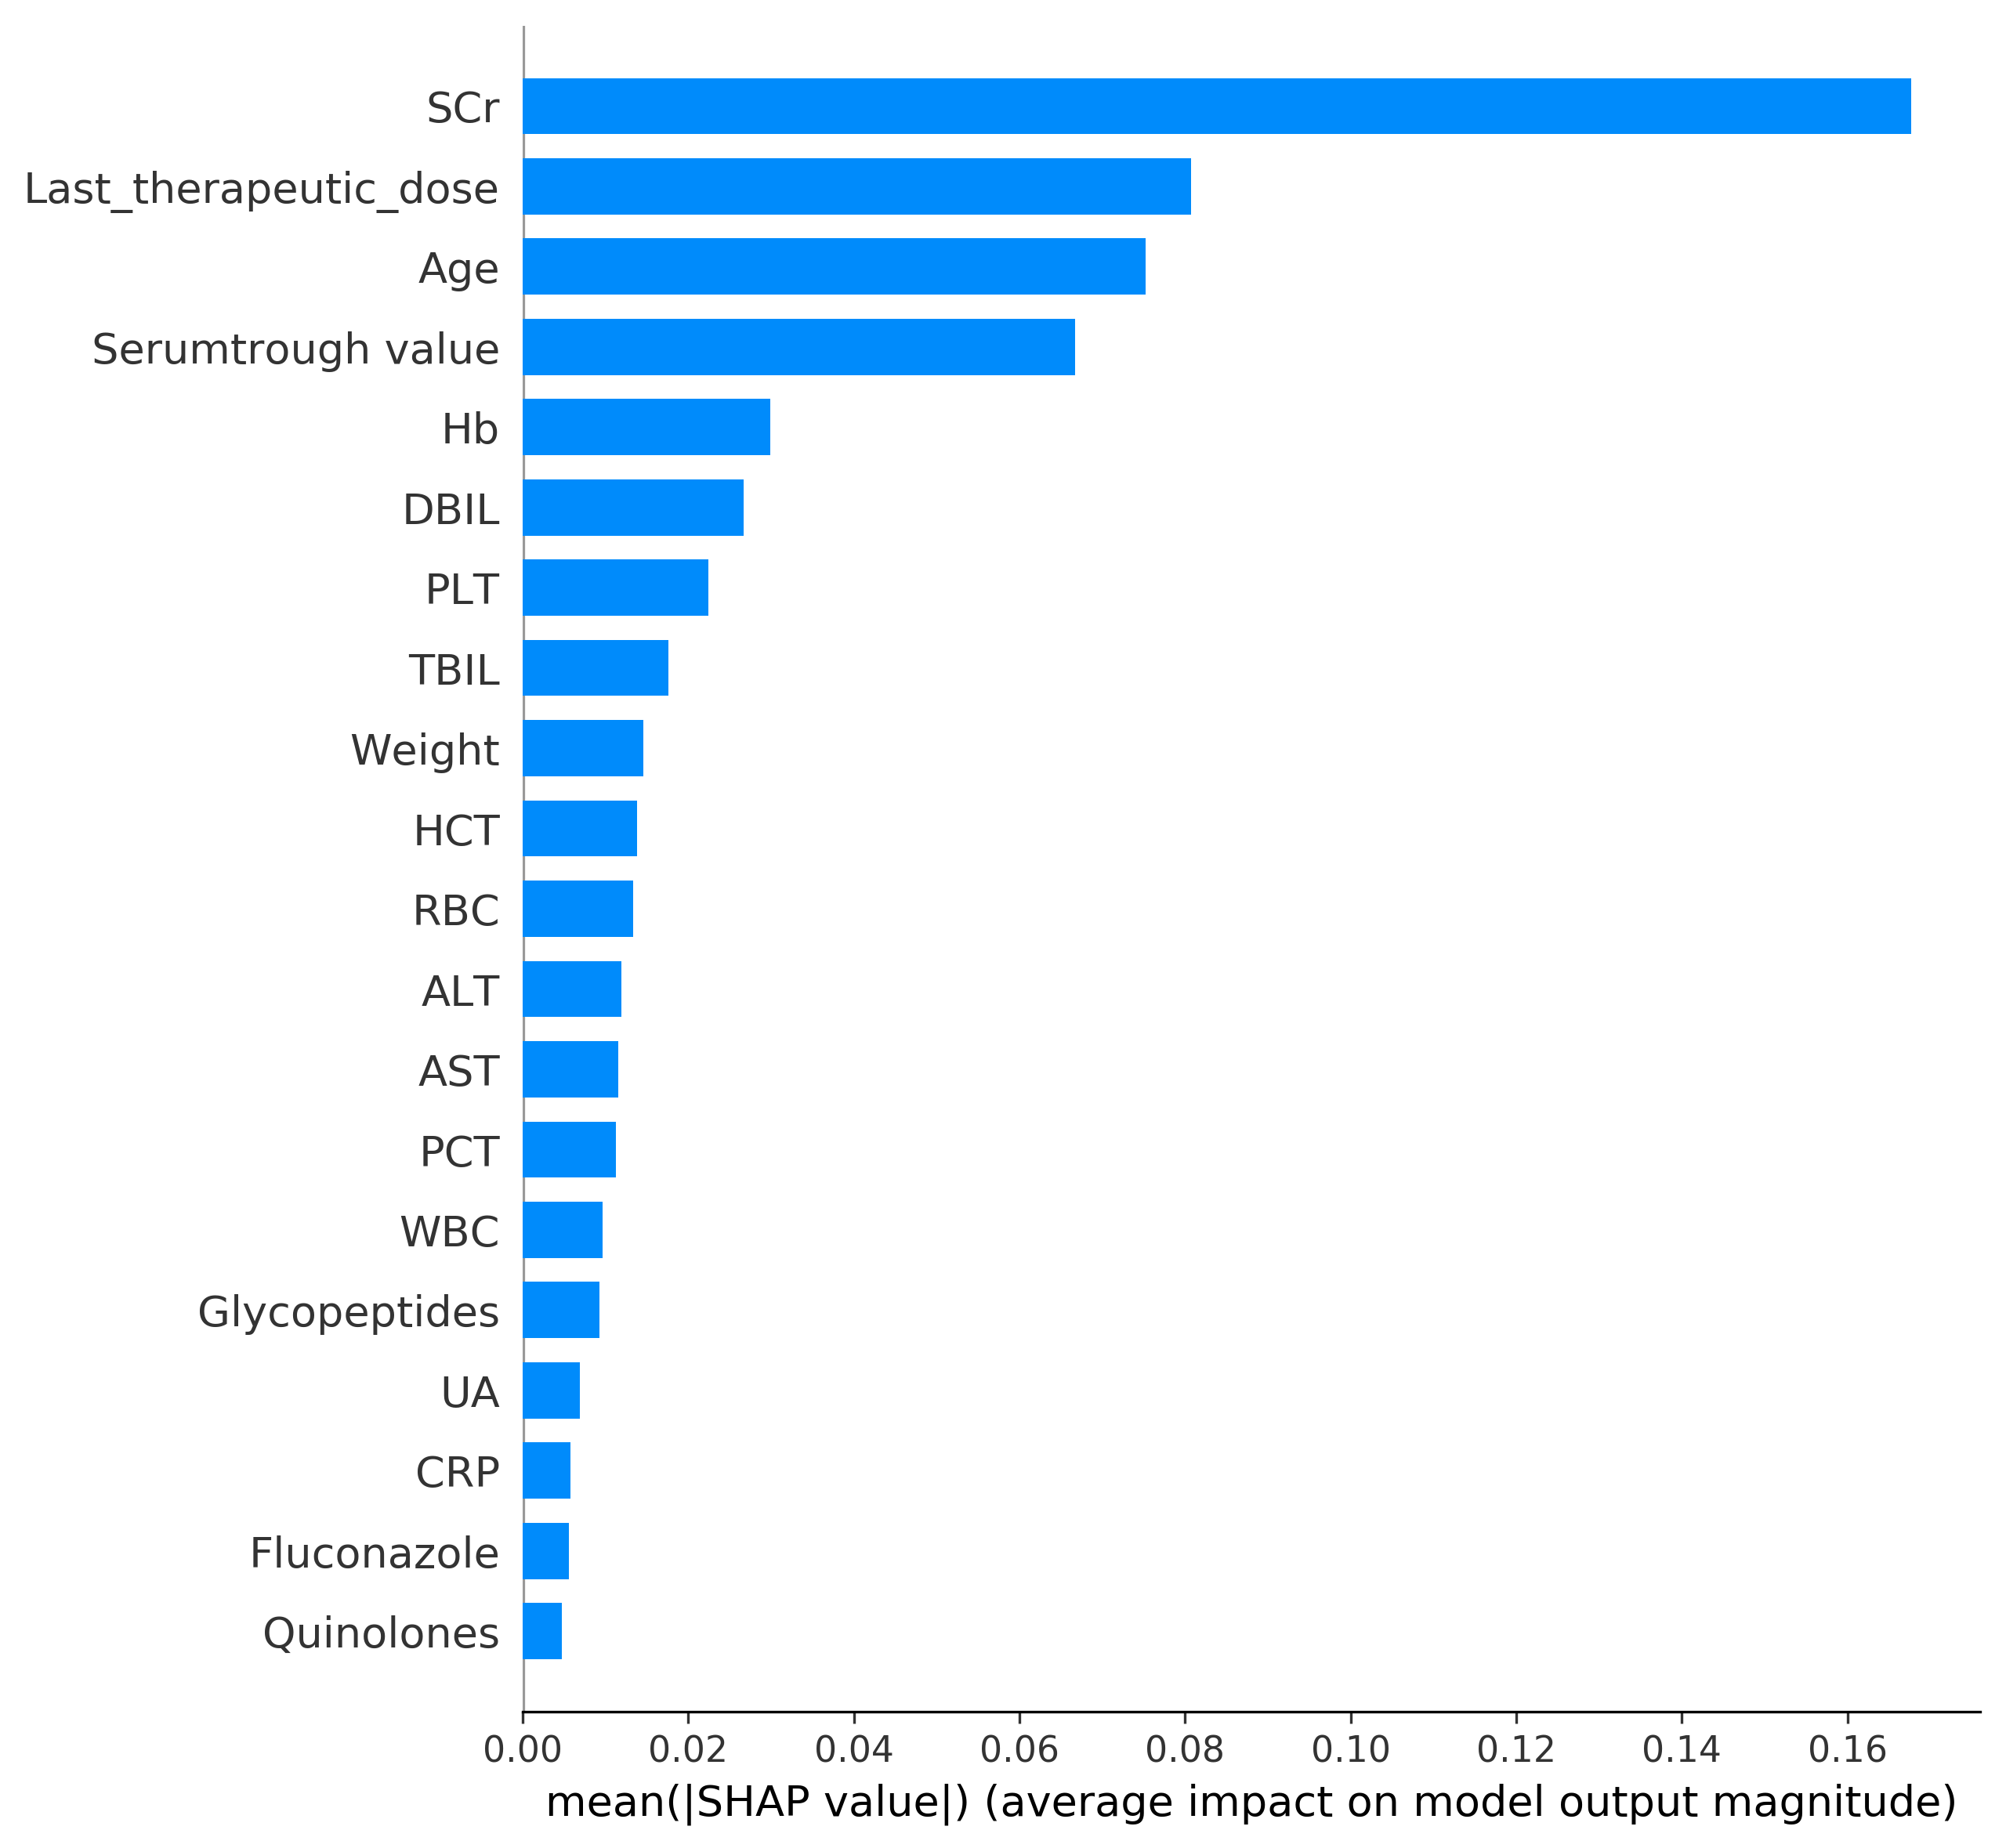

In [129]:
shap.summary_plot(shap_values, tran_x, plot_type="bar")

In [130]:
b = []
for i in range(shap_values.shape[1]):
    s = 0
    for j in range(shap_values.shape[0]):
        s += abs(shap_values[j][i])
    b.append(round(s/shap_values.shape[0],4))

In [132]:
df_sv_sum = pd.DataFrame({'Variable Name':list(tran_x.columns),'Shap Value':b})
df_sv_sum_1 = df_sv_sum.sort_values('Shap Value',ascending=False)
df_sv_sum_1 = df_sv_sum_1.reset_index()
del df_sv_sum_1['index']

df_sv_sum_1.loc[0:22]

,Variable Name,Shap Value
0,SCr,0.1677
1,Last_therapeutic_dose,0.0808
2,Age,0.0752
3,Serumtrough value,0.0667
4,Hb,0.0299
5,DBIL,0.0267
6,PLT,0.0225
7,TBIL,0.0176
8,Weight,0.0146
9,HCT,0.0138


In [133]:
# Remove the list name of tranx for top10
shap_list = list(im_auto['Variable Name'])
tranx_list = list(tran_x.columns)

# Remove the index corresponding to the top20 list
a_list = []
for i in shap_list:
    a_list.append(tranx_list.index(i))
    
# Remove the shap value of topX and dataframe
tran_x_1 = tran_x[shap_list]
shap_values_1 = shap_values[:,a_list]

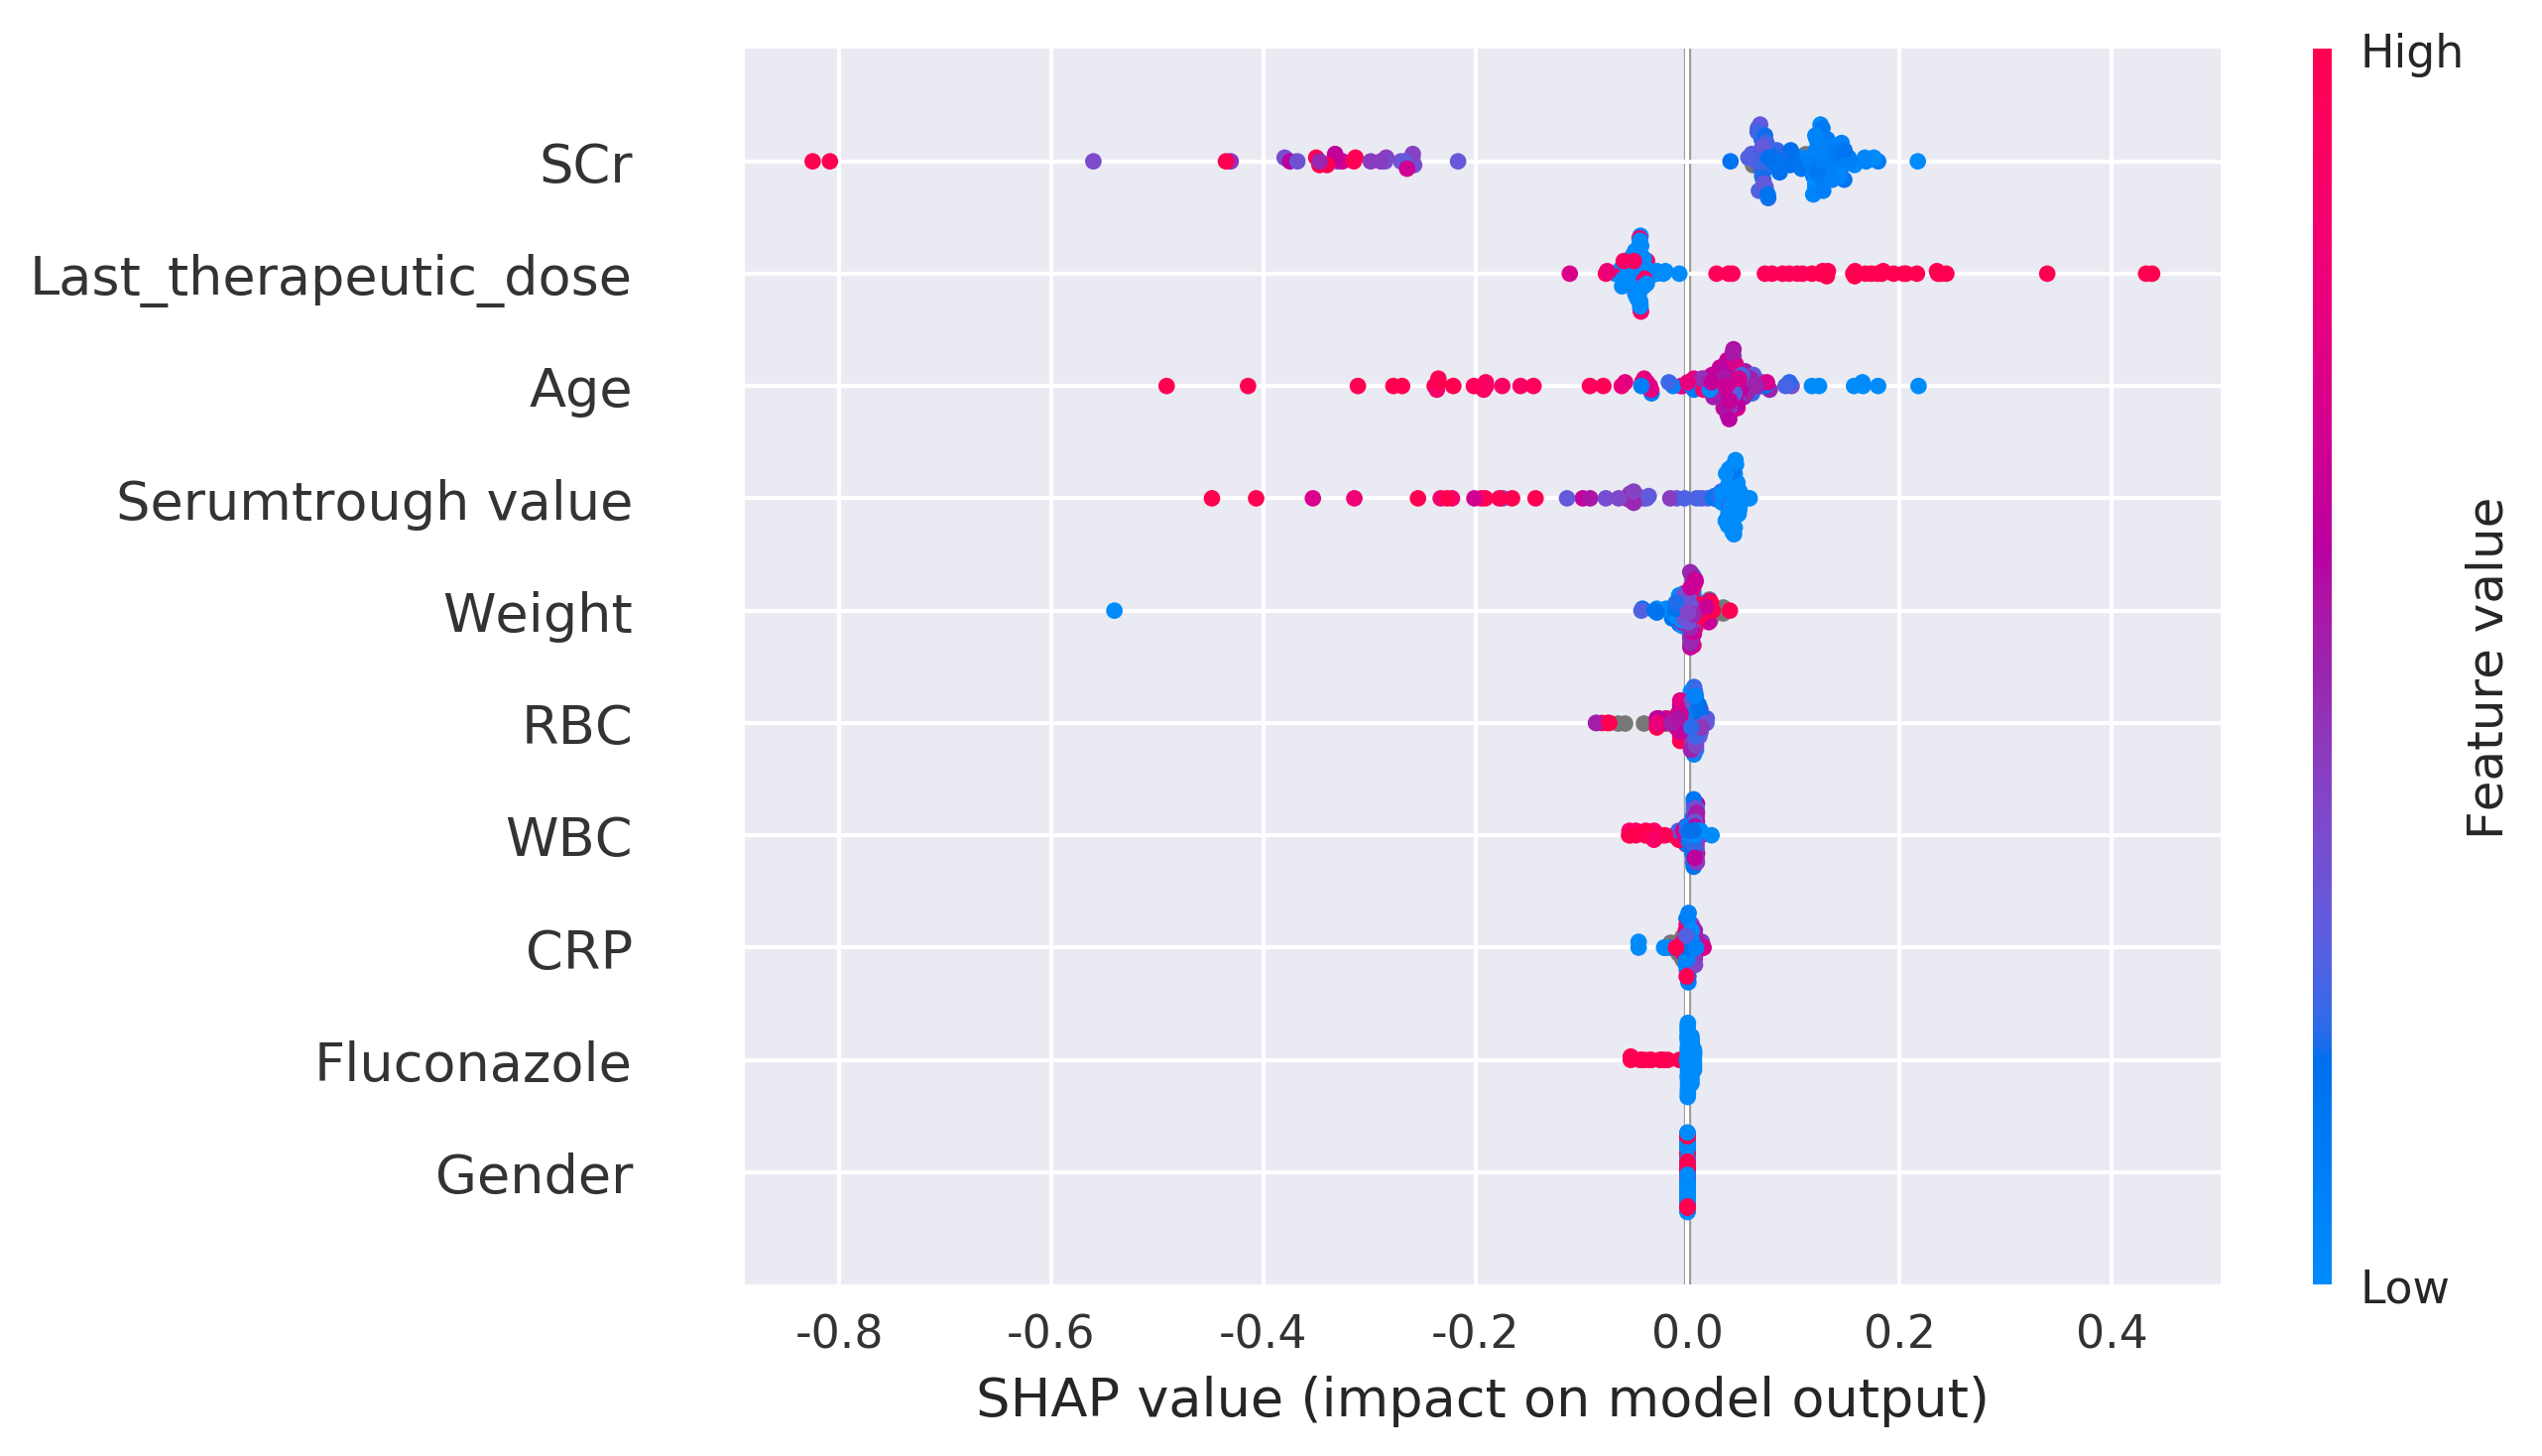

In [134]:
from matplotlib import pyplot as plt;  plt.style.use('seaborn')
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
mpl.rcParams['axes.unicode_minus'] = False

import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 

shap.initjs()
shap.summary_plot(shap_values_1, tran_x_1)


## XGBoost —— Interactive Variables

In [379]:
df_feature_1 = pd.read_excel(r'../data/df_Interactive Variables.xlsx')
del df_feature_1['index']

In [380]:
df_old_feature = df_feature_1[df_feature_1['type'] == 'old']
df_new_feature = df_feature_1[df_feature_1['type'] == 'new']

df_old_feature = df_old_feature.drop(columns=['type'])
df_new_feature = df_new_feature.drop(columns=['type'])

df_old_feature = df_old_feature.reset_index()
del df_old_feature['index']

df_new_feature = df_new_feature.reset_index()
del df_new_feature['index']

In [381]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb

In [382]:
from sklearn.model_selection import train_test_split
x_old_feature = df_old_feature.iloc[:,1:]
y_old_feature = df_old_feature['万古霉素日剂量']
tran_x_old_feature,test_x_old_feature,tran_y_old_feature,test_y_old_feature = train_test_split(x_old_feature,y_old_feature,test_size=0.3,random_state = 60)
x_new_feature = df_new_feature.iloc[:,1:]
y_new_feature = df_new_feature['万古霉素日剂量']
tran_x_new_feature,test_x_new_feature,tran_y_new_feature,test_y_new_feature = train_test_split(x_new_feature,y_new_feature,test_size=0.3,random_state = 60)

tran_x_new_feature.index += 1000
test_x_new_feature.index += 1000
tran_y_new_feature.index += 1000
test_y_new_feature.index += 1000
# 训练集
tran_x_feature = pd.concat([tran_x_old_feature,tran_x_new_feature],axis=0)
tran_y_feature = pd.concat([tran_y_old_feature,tran_y_new_feature],axis=0)
# 测试集
test_x_feature = pd.concat([test_x_old_feature,test_x_new_feature],axis=0)
test_y_feature = pd.concat([test_y_old_feature,test_y_new_feature],axis=0)
# ===========================================  Model =========================================== 
from auto_ml import Predictor
from auto_ml.utils import get_boston_dataset

column_descriptions = {
    '万古霉素日剂量': 'output' 
}
ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)

ml_predictor.train(tran_x_feature, model_names=['XGBRegressor'])

test_score = ml_predictor.score(test_x_feature, test_x_feature['万古霉素日剂量'])
file_name = ml_predictor.save()
trained_model = load_ml_model(file_name)

predictions = ml_predictor.predict(test_x_feature)

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}
Running basic data cleaning
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


********************************************************************************************
About to fit the pipeline for the model XGBRegressor to predict 万古霉素日剂量
Started at:
2021-03-29 21:48:47
[21:48:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarede

In [383]:
x_old_feature = df_old_feature.iloc[:,1:]
y_old_feature =df_old_feature['万古霉素日剂量']
tran_x_old_feature,test_x_old_feature,tran_y_old_feature,test_y_old_feature=train_test_split(x_old_feature.drop(columns=['万古霉素日剂量']),y_old_feature,test_size=0.3,random_state = 60)
x_new_feature = df_new_feature.iloc[:,1:]
y_new_feature = df_new_feature['万古霉素日剂量']
tran_x_new_feature,test_x_new_feature,tran_y_new_feature,test_y_new_feature=train_test_split(x_new_feature.drop(columns=['万古霉素日剂量']),y_new_feature,test_size=0.3,random_state = 60)

tran_x_new_feature.index += 1000
test_x_new_feature.index += 1000
tran_y_new_feature.index += 1000
test_y_new_feature.index += 1000
# 训练集
tran_x_feature = pd.concat([tran_x_old_feature,tran_x_new_feature],axis=0)
tran_y_feature = pd.concat([tran_y_old_feature,tran_y_new_feature],axis=0)
# 测试集
test_x_feature = pd.concat([test_x_old_feature,test_x_new_feature],axis=0)
test_y_feature = pd.concat([test_y_old_feature,test_y_new_feature],axis=0)
#============================= model ==================================
trained_model = load_ml_model(file_name)
params = trained_model.named_steps['final_model'].model.get_params()

model = xgb.XGBRegressor(**params)
eval_set = [(test_x_feature, test_y_feature)]
clt = model.fit(tran_x_feature,tran_y_feature,early_stopping_rounds=50,eval_set=eval_set,verbose=False)
y_pred_feature = clt.predict(test_x_feature)

b.append(r2_score(test_y_feature,y_pred_feature,multioutput='variance_weighted'))

[21:48:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:48:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [384]:
print('R2:  ',r2_score(test_y_feature,y_pred_feature,multioutput='variance_weighted'))
print('MSE: ',mean_squared_error(test_y_feature,y_pred_feature))
print('RMSE:',mean_squared_error(test_y_feature,y_pred_feature) ** 0.5)
print('MAE: ',mean_absolute_error(test_y_feature,y_pred_feature))

R2:   0.43160202473214726
MSE:  0.12108500668790884
RMSE: 0.34797270968843064
MAE:  0.26192887979410473


In [248]:
im=pd.DataFrame({'Variable Name':tran_x_feature.columns,'Importance Score':model.feature_importances_})
im=im.sort_values(by='Importance Score',ascending=False)

im=im.reset_index()
del im['index']
im['Importance Score']=round(im['Importance Score'],4)
im = im[0:10]


,Variable Name,Importance Score
0,红细胞压积_偏低 * 肌酐_偏高,0.0594
1,上一次万古霉素日剂量_小于1000mg * 肌酐_偏高,0.0554
2,总蛋白_偏低 * 肌酐_偏高,0.0325
3,喹诺酮类 * 肌酐_偏高,0.0270
4,上一次TDM值_大于20 * 尿酸_偏高,0.0229
5,体重_分段_偏低 * 血小板计数_偏低,0.0199
6,性别_女 * 肌酐_偏高,0.0194
7,性别_男 * 血红蛋白_偏低,0.0172
8,上一次TDM值_10到20 * 尿酸_偏高,0.0168
9,糖肽类抗菌药 * 降钙素原_偏高,0.0156


In [251]:
import shap
explainer = shap.TreeExplainer(model)

# shap值
shap_values = explainer.shap_values(tran_x_feature)

# 模型的基线ybase     (通常是所有样本的目标变量的均值)
y_base = explainer.expected_value
print(y_base)
y_pred_1 = model.predict(tran_x_feature)  # 这里是训练集的预测值，不是   *****
print(y_pred_1.mean())


7.3303533
7.330354


In [252]:
b = []
for i in range(shap_values.shape[1]):
    s = 0
    for j in range(shap_values.shape[0]):
        s += abs(shap_values[j][i])
#     print(n)
    b.append(round(s/shap_values.shape[0],4))

In [253]:
df_sv_sum = pd.DataFrame({'Variable Name':list(tran_x_feature.columns),'Shap Value':b})
df_sv_sum_1 = df_sv_sum.sort_values('Shap Value',ascending=False)
df_sv_sum_1 = df_sv_sum_1.reset_index()
del df_sv_sum_1['index']

In [254]:
# # df_sv_sum_1[df_sv_sum_1['Variable Name']=='喹诺酮类 * 肌酐_偏高']
# df_sv_sum_1.iloc[0:22]

,Variable Name,Shap Value
0,年龄_分段_大于60岁 * 总蛋白_偏低,0.0618
1,红细胞压积_偏低 * 肌酐_偏高,0.0443
2,性别_女 * 肌酐_偏高,0.0406
3,上一次TDM值_小于10 * 年龄_分段_18到60岁,0.0374
4,总蛋白_偏低 * 肌酐_偏高,0.0260
5,体重_分段_偏低 * 血小板计数_偏低,0.0250
6,上一次TDM值_大于20 * 尿酸_偏高,0.0235
7,上一次万古霉素日剂量_小于1000mg * 肌酐_偏高,0.0230
8,尿酸_偏低 * 氨基糖苷类,0.0174
9,性别_女 * 袢利尿剂,0.0166


In [266]:
# #  取出 top 10的 tran_x的列名
shap_list = list(im_cross_auto['Variable Name'])
tranx_list = list(tran_x_feature.columns)

# 取出 top20 列名对应的index
a_list = []
for i in shap_list:
    a_list.append(tranx_list.index(i))
    
# 取出 top_X  的shap值和dataframe
tran_x_1 = tran_x_feature[shap_list]
tran_x_1 = tran_x_1.rename(columns={'红细胞压积_偏低 * 肌酐_偏高':'HCT_L + SCr_H',
                    '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高':'Last therapeutic dose_L + SCr_h',
                    '总蛋白_偏低 * 肌酐_偏高':'TP_L + SCr_H',
                    '喹诺酮类 * 肌酐_偏高':'Quinolones + SCr_H',
                    '上一次TDM值_大于20 * 尿酸_偏高':'Serum trough value_H + UA_H',
                    '体重_分段_偏低 * 血小板计数_偏低':'Weight_L + PLT_L',
                    '年龄_分段_大于60岁 * 肌酐_偏高':'Age_H + SCr_H',
                    '性别_女 * 肌酐_偏高':'Gender_female + SCr_H',
                    '性别_男 * 血红蛋白_偏低':'Gender_female + Hb_L',
                    '上一次TDM值_10到20 * 尿酸_偏高':'Serum trough value_M + UA_H'})

shap_values_1 = shap_values[:,a_list]

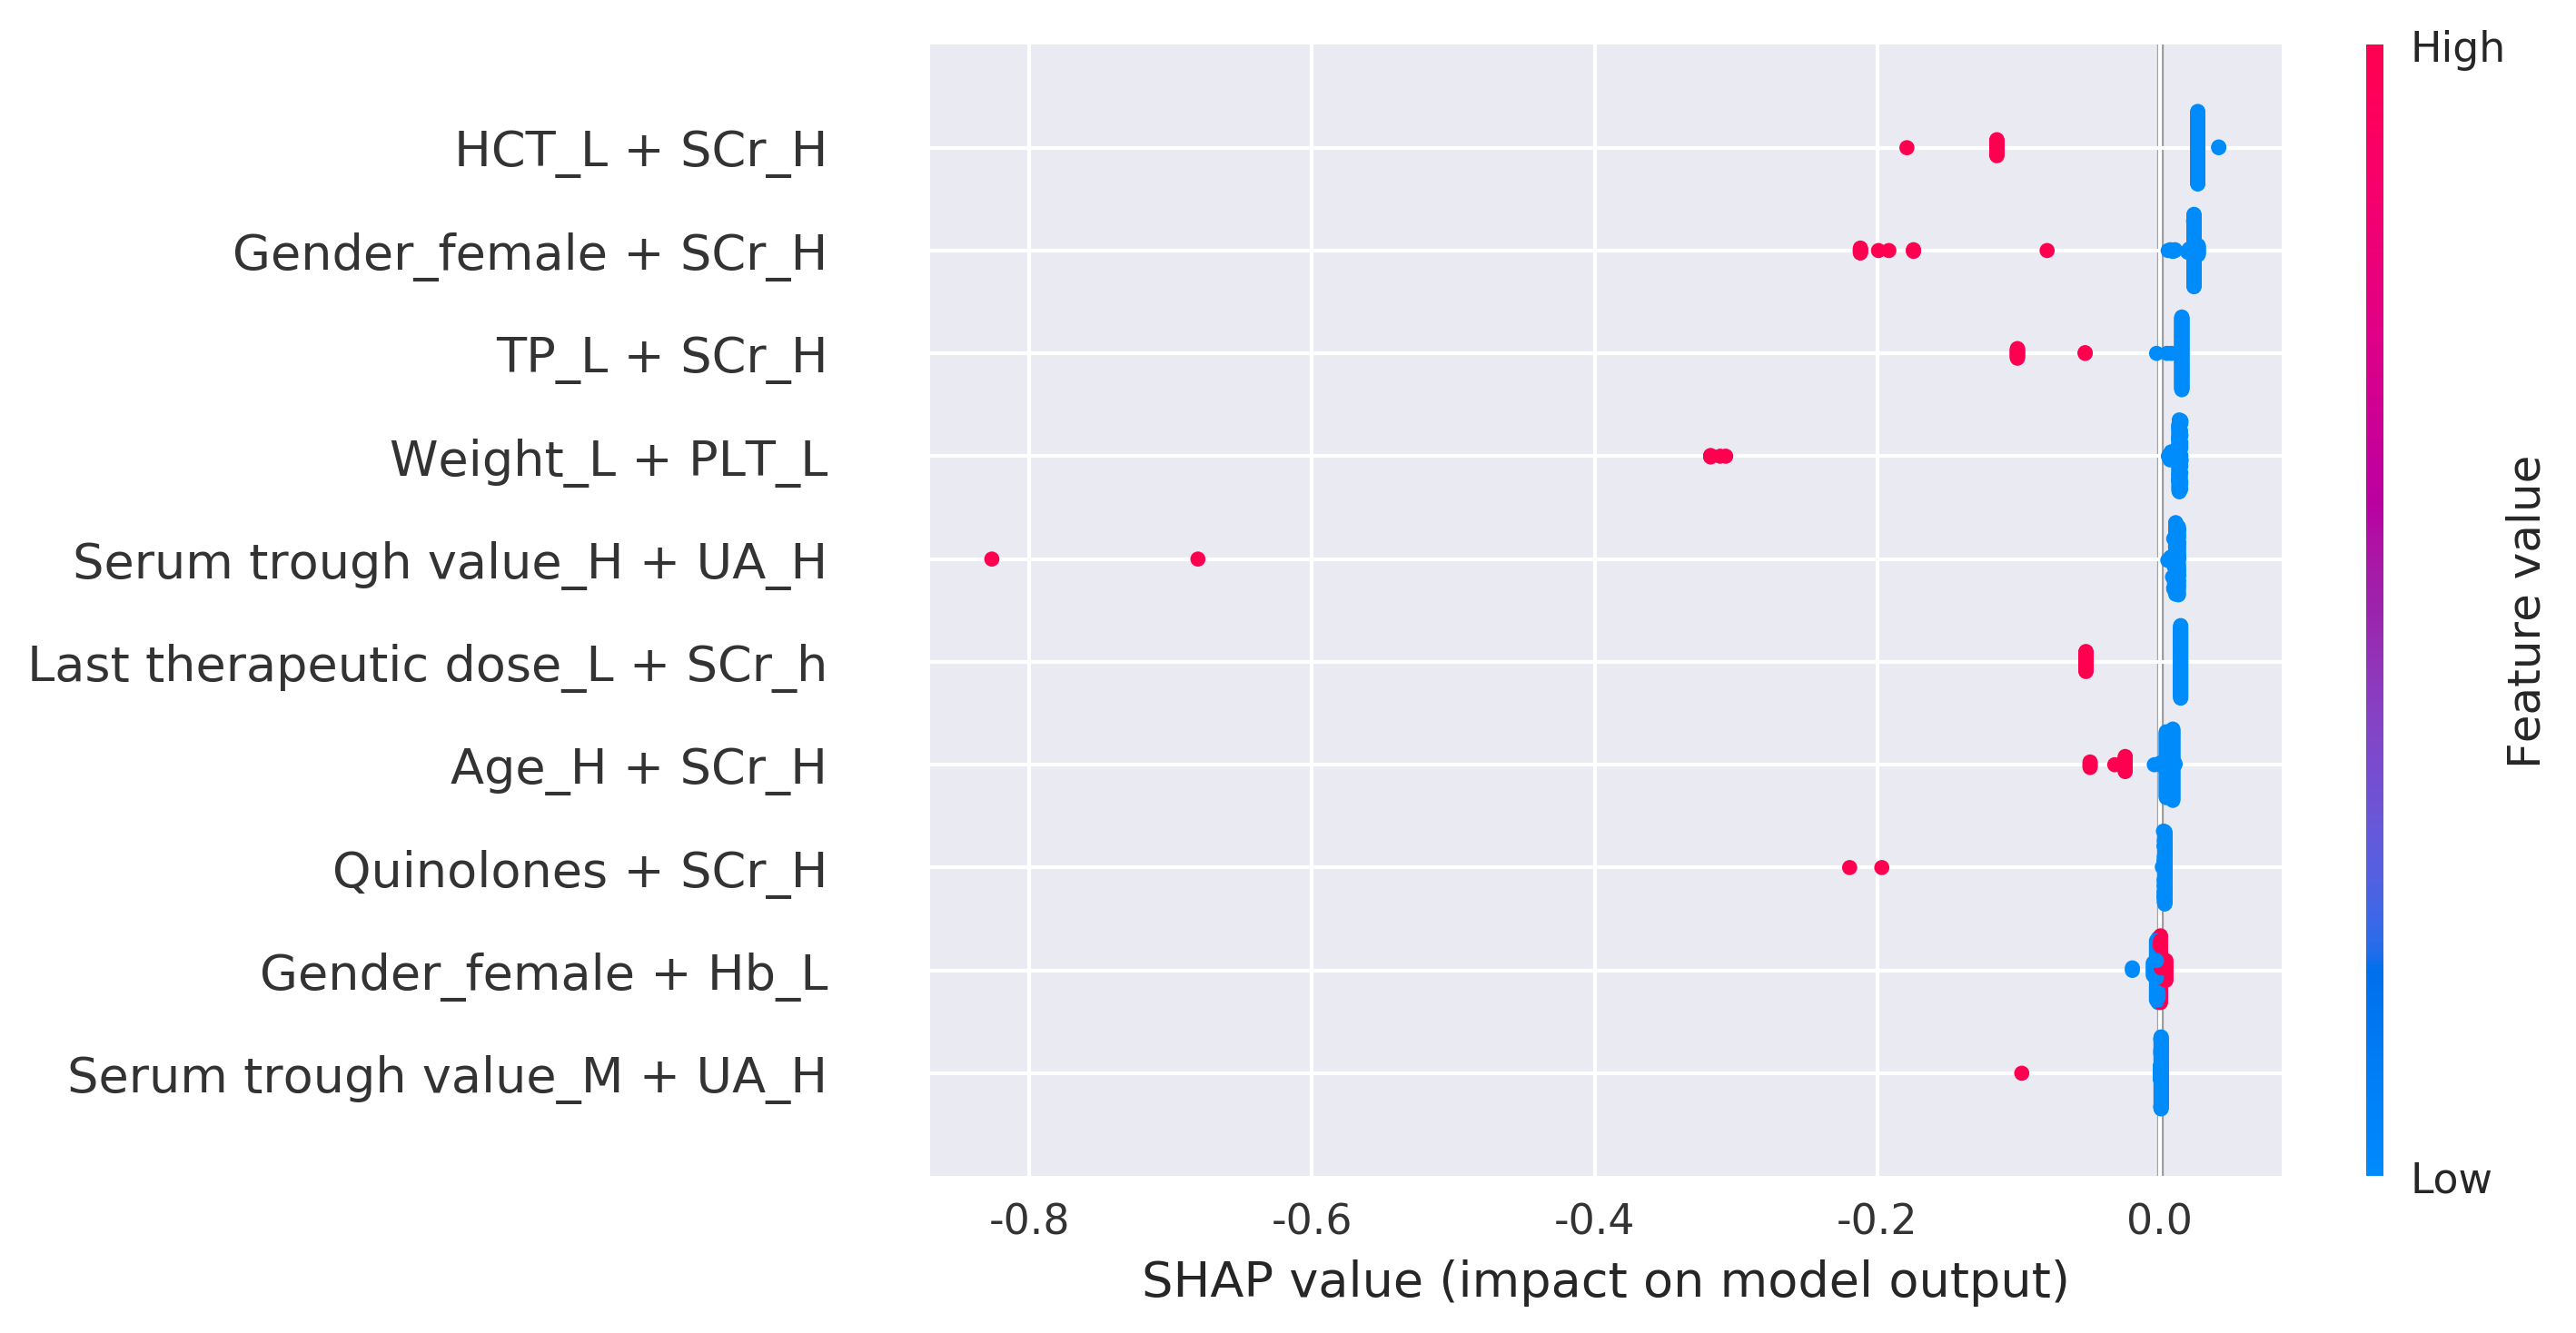

In [268]:
from matplotlib import pyplot as plt;  plt.style.use('seaborn')
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
mpl.rcParams['axes.unicode_minus'] = False

import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 

shap.initjs()
shap.summary_plot(shap_values_1, tran_x_1)


# Single factor and Interactive Variables

In [273]:
df_old_1.columns

Index(['patient_id', 'Age', 'Gender', 'Weight', 'Therapeutic_dose',
       'Last_therapeutic_dose', 'Last_Serumtrough_value', 'Serumtrough value',
       'Glycopeptides', 'Loop_diuretics', 'Aminoglycosides', 'Fluconazole',
       'Quinolones', 'Immunosuppressors', 'UA', 'SCr', 'PCT', 'CRP', 'ALT',
       'AST', 'TBIL', 'DBIL', 'TP', 'RBC', 'WBC', 'PLT', 'Hb', 'HCT'],
      dtype='object')

In [274]:
df_single_old = df_old[['patient_id','Therapeutic_dose','Pre_Serumtrough_value',
                     'SCr','Last_therapeutic_dose','Serumtrough value','RBC','Age', 
                     'Weight','Fluconazole','Gender','CRP','WBC']]

df_single_new = df_new[['patient_id','Therapeutic_dose','Pre_Serumtrough_value',
                     'SCr','Last_therapeutic_dose','Serumtrough value','RBC','Age', 
                     'Weight','Fluconazole','Gender','CRP','WBC']]

In [275]:
df_feature_old = df_old_feature[['红细胞压积_偏低 * 肌酐_偏高', '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高', 
                                 '总蛋白_偏低 * 肌酐_偏高', '喹诺酮类 * 肌酐_偏高', '上一次TDM值_大于20 * 尿酸_偏高',
                                 '体重_分段_偏低 * 血小板计数_偏低','年龄_分段_大于60岁 * 肌酐_偏高',
                                 '性别_女 * 肌酐_偏高', '性别_男 * 血红蛋白_偏低','上一次TDM值_10到20 * 尿酸_偏高',
                                 ]]

df_feature_new = df_new_feature[['红细胞压积_偏低 * 肌酐_偏高', '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高', 
                                 '总蛋白_偏低 * 肌酐_偏高', '喹诺酮类 * 肌酐_偏高', '上一次TDM值_大于20 * 尿酸_偏高',
                                 '体重_分段_偏低 * 血小板计数_偏低','年龄_分段_大于60岁 * 肌酐_偏高',
                                 '性别_女 * 肌酐_偏高', '性别_男 * 血红蛋白_偏低','上一次TDM值_10到20 * 尿酸_偏高',]]

In [280]:
df_feature_old = df_feature_old.rename(columns={'红细胞压积_偏低 * 肌酐_偏高':'HCT_L + SCr_H',
                    '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高':'Last therapeutic dose_L + SCr_h',
                    '总蛋白_偏低 * 肌酐_偏高':'TP_L + SCr_H',
                    '喹诺酮类 * 肌酐_偏高':'Quinolones + SCr_H',
                    '上一次TDM值_大于20 * 尿酸_偏高':'Serum trough value_H + UA_H',
                    '体重_分段_偏低 * 血小板计数_偏低':'Weight_L + PLT_L',
                    '年龄_分段_大于60岁 * 肌酐_偏高':'Age_H + SCr_H',
                    '性别_女 * 肌酐_偏高':'Gender_female + SCr_H',
                    '性别_男 * 血红蛋白_偏低':'Gender_female + Hb_L',
                    '上一次TDM值_10到20 * 尿酸_偏高':'Serum trough value_M + UA_H'})

df_feature_new = df_feature_new.rename(columns={'红细胞压积_偏低 * 肌酐_偏高':'HCT_L + SCr_H',
                    '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高':'Last therapeutic dose_L + SCr_h',
                    '总蛋白_偏低 * 肌酐_偏高':'TP_L + SCr_H',
                    '喹诺酮类 * 肌酐_偏高':'Quinolones + SCr_H',
                    '上一次TDM值_大于20 * 尿酸_偏高':'Serum trough value_H + UA_H',
                    '体重_分段_偏低 * 血小板计数_偏低':'Weight_L + PLT_L',
                    '年龄_分段_大于60岁 * 肌酐_偏高':'Age_H + SCr_H',
                    '性别_女 * 肌酐_偏高':'Gender_female + SCr_H',
                    '性别_男 * 血红蛋白_偏低':'Gender_female + Hb_L',
                    '上一次TDM值_10到20 * 尿酸_偏高':'Serum trough value_M + UA_H'})

In [276]:
print(df_single_old.shape)
print(df_feature_old.shape)

(117, 13)
(117, 10)


In [282]:
df_old_common = pd.concat([df_single_old,df_feature_old],axis=1)
df_new_common = pd.concat([df_single_new,df_feature_new],axis=1)

df_old_common['Therapeutic_dose'] = df_old_common['Therapeutic_dose'].apply(lambda x: math.log(x) if x>0 else 0)   # log取得时候， x不能取到0
df_new_common['Therapeutic_dose'] = df_new_common['Therapeutic_dose'].apply(lambda x: math.log(x) if x>0 else 0)
df_old_common['Last_therapeutic_dose'] = df_old_common['Last_therapeutic_dose'].apply(lambda x: math.log(x) if x>0 else 0)   # log取得时候， x不能取到0
df_new_common['Last_therapeutic_dose'] = df_new_common['Last_therapeutic_dose'].apply(lambda x: math.log(x) if x>0 else 0)

In [283]:
print(df_old_common.shape)
print(df_new_common.shape)

(117, 23)
(67, 23)


In [289]:
from sklearn.model_selection import train_test_split
x_old_common = df_old_common.iloc[:,1:]
y_old_common = df_old_common['Therapeutic_dose']
tran_x_old_common,test_x_old_common,tran_y_old_common,test_y_old_common = train_test_split(x_old_common,y_old_common,test_size=0.3,random_state = 327)
x_new_common = df_new_common.iloc[:,1:]
y_new_common = df_new_common['Therapeutic_dose']
tran_x_new_common,test_x_new_common,tran_y_new_common,test_y_new_common = train_test_split(x_new_common,y_new_common,test_size=0.3,random_state = 327)

tran_x_new_common.index += 1000
test_x_new_common.index += 1000
tran_y_new_common.index += 1000
test_y_new_common.index += 1000
# 训练集
tran_x_common = pd.concat([tran_x_old_common,tran_x_new_common],axis=0)
tran_y_common = pd.concat([tran_y_old_common,tran_y_new_common],axis=0)
# 测试集
test_x_common = pd.concat([test_x_old_common,test_x_new_common],axis=0)
test_y_common = pd.concat([test_y_old_common,test_y_new_common],axis=0)
# ===========================================  Model =========================================== 
from auto_ml import Predictor
from auto_ml.utils_models import load_ml_model

column_descriptions = {
    'Therapeutic_dose': 'output' 
}
ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)
ml_predictor.train(tran_x_common.drop(columns=['Pre_Serumtrough_value']), model_names=['XGBRegressor'])

test_score = ml_predictor.score(test_x_common.drop(columns=['Pre_Serumtrough_value']), test_x_common['Therapeutic_dose'])
file_name = ml_predictor.save()
trained_model = load_ml_model(file_name)

predictions = ml_predictor.predict(test_x_common.drop(columns=['Pre_Serumtrough_value']))

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}
Running basic data cleaning
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


********************************************************************************************
About to fit the pipeline for the model XGBRegressor to predict Therapeutic_dose
Started at:
2021-03-29 20:55:21
[20:55:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg

In [285]:
x_old_common = df_old_common.iloc[:,1:]
y_old_common =df_old_common['Therapeutic_dose']
tran_x_old_common,test_x_old_common,tran_y_old_common,test_y_old_common=train_test_split(x_old_common.drop(columns=['Therapeutic_dose']),y_old_common,test_size=0.3,random_state = 327)
x_new_common = df_new_common.iloc[:,1:]
y_new_common = df_new_common['Therapeutic_dose']
tran_x_new_common,test_x_new_common,tran_y_new_common,test_y_new_common=train_test_split(x_new_common.drop(columns=['Therapeutic_dose']),y_new_common,test_size=0.3,random_state = 327)

tran_x_new_common.index += 1000
test_x_new_common.index += 1000
tran_y_new_common.index += 1000
test_y_new_common.index += 1000
# Training Data
tran_x_common = pd.concat([tran_x_old_common,tran_x_new_common],axis=0)
tran_y_common = pd.concat([tran_y_old_common,tran_y_new_common],axis=0)
# Test Data
test_x_common = pd.concat([test_x_old_common,test_x_new_common],axis=0)
test_y_common = pd.concat([test_y_old_common,test_y_new_common],axis=0)


trained_model = load_ml_model(file_name)
params = trained_model.named_steps['final_model'].model.get_params()

model = xgb.XGBRegressor(**params)
eval_set = [(test_x_common.drop(columns=['Pre_Serumtrough_value']), test_y_common)]
clt = model.fit(tran_x_common.drop(columns=['Pre_Serumtrough_value']),tran_y_common,early_stopping_rounds=50,eval_set=eval_set,verbose=False)
y_pred_common = clt.predict(test_x_common.drop(columns=['Pre_Serumtrough_value']))

))

[20:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:31:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [286]:
print('R2:  ',r2_score(test_y_common,y_pred_common,multioutput='variance_weighted'))
print('MSE: ',mean_squared_error(test_y_common,y_pred_common))
print('RMSE:',mean_squared_error(test_y_common,y_pred_common) ** 0.5)
print('MAE: ',mean_absolute_error(test_y_common,y_pred_common))

R2:   0.6749075189916672
MSE:  0.09657385568308631
RMSE: 0.31076334353183666
MAE:  0.2118113748775765


# Subgroups Analysis

In [355]:
x_old_common = df_old_common.iloc[:,1:]
y_old_common = df_old_common['Therapeutic_dose']
tran_x_old_common,test_x_old_common,tran_y_old_common,test_y_old_common = train_test_split(x_old_common,y_old_common,test_size=0.3,random_state = 327)
x_new_common = df_new_common.iloc[:,1:]
y_new_common = df_new_common['Therapeutic_dose']
tran_x_new_common,test_x_new_common,tran_y_new_common,test_y_new_common = train_test_split(x_new_common,y_new_common,test_size=0.3,random_state = 327)

tran_x_new_common.index += 1000
test_x_new_common.index += 1000
tran_y_new_common.index += 1000
test_y_new_common.index += 1000
# Training Data
tran_x_common = pd.concat([tran_x_old_common,tran_x_new_common],axis=0)
tran_y_common = pd.concat([tran_y_old_common,tran_y_new_common],axis=0)
# Test Data
test_x_common = pd.concat([test_x_old_common,test_x_new_common],axis=0)
test_y_common = pd.concat([test_y_old_common,test_y_new_common],axis=0)

In [356]:
# 亚组分析的指标
test_x_common['Therapeutic_dose_predictions'] = y_pred_common
test_x_common['Gender_number'] = test_x_common['Gender'].apply(lambda x: 1 if x==1 else 0.85)

test_x_common = test_x_common.eval('Serum_creatinine_clearance = ((140 - Age) * Weight * Gender_number) / (0.818 * SCr)')

In [359]:
def dp_weight(x,y):
    if x<=60 and y==0:
        z='L'
    elif x>=70 and y==0:
        z='H'
    elif x<=50 and y==1:
        z='L'
    elif x>=60 and y==1:
        z='H'
    else:
        z='M'
    return z
for i in test_x_common.index:
    test_x_common.loc[i,'Weight_Group']=dp_weight(test_x_common.loc[i,'Weight'],test_x_common.loc[i,'Gender'])
#  Groups
test_x_common['TDM_Group']=test_x_common['Pre_Serumtrough_value'].apply(lambda x: 0 if x<10 else 1 if 10<=x<15 else 2 if 15<=x<20 else 3 if 10<=x<20 else 4 if 20<=x else x)
test_x_common['Serum_creatinine_clearance_Group'] = test_x_common['Serum_creatinine_clearance'].apply(lambda x: 0 if 40<=x<60 else 1 if 60<=x<80 else 2 if 80<=x<100 else 3 if x>=100 else x )

In [361]:
import math
test_x_common['Therapeutic_dose'] = test_x_common['Therapeutic_dose'].apply(lambda x: round((math.e) ** x,0))
test_x_common['Therapeutic_dose_predictions'] = test_x_common['Therapeutic_dose_predictions'].apply(
                                                                lambda x: round((math.e) ** x,0))

In [362]:
test_x_common = test_x_common.eval('Prediction_accuracy = (Therapeutic_dose_predictions - Therapeutic_dose)/ Therapeutic_dose')
test_x_common['Prediction_accuracy_5'] = test_x_common['Prediction_accuracy'].apply(lambda x:1 if abs(x)<=0.05 else 0)
test_x_common['Prediction_accuracy_10'] = test_x_common['Prediction_accuracy'].apply(lambda x:1 if abs(x)<=0.1 else 0)
test_x_common['Prediction_accuracy_15'] = test_x_common['Prediction_accuracy'].apply(lambda x:1 if abs(x)<=0.15 else 0)
test_x_common['Prediction_accuracy_20'] = test_x_common['Prediction_accuracy'].apply(lambda x:1 if abs(x)<=0.2 else 0)
test_x_common['Prediction_accuracy_25'] = test_x_common['Prediction_accuracy'].apply(lambda x:1 if abs(x)<=0.25 else 0)
test_x_common['Prediction_accuracy_30'] = test_x_common['Prediction_accuracy'].apply(lambda x:1 if abs(x)<=0.3 else 0)
test_x_common['Prediction_accuracy'] = test_x_common['Prediction_accuracy'].apply(lambda x:1 if abs(x)<=0.2 else 0)

In [363]:
print('accuracy:',(test_x_common[test_x_common['Prediction_accuracy']==1].shape[0])/(test_x_common.shape[0]))

accuracy: 0.7017543859649122


In [364]:
##  WeightGroup
W_aaa=test_x_common[test_x_common['Weight_Group']=='L']
W_bbb=test_x_common[test_x_common['Weight_Group']=='M']
W_ccc=test_x_common[test_x_common['Weight_Group']=='H']
print('Weight_L:',W_aaa[W_aaa['Prediction_accuracy']==1].shape[0],' ',W_aaa.shape[0],
      '   female-male：',W_aaa[(W_aaa['Prediction_accuracy']==1)&(W_aaa['Gender']==0)].shape[0],W_aaa[(W_aaa['Prediction_accuracy']==1)&(W_aaa['Gender']==1)].shape[0],
      ' ',W_aaa[(W_aaa['Gender']==0)].shape[0],W_aaa[(W_aaa['Gender']==1)].shape[0])
print('Weight_M:',W_bbb[W_bbb['Prediction_accuracy']==1].shape[0],' ',W_bbb.shape[0],
      '   female-male：',W_bbb[(W_bbb['Prediction_accuracy']==1)&(W_bbb['Gender']==0)].shape[0],W_bbb[(W_bbb['Prediction_accuracy']==1)&(W_bbb['Gender']==1)].shape[0],
      ' ',W_bbb[(W_bbb['Gender']==0)].shape[0],W_bbb[(W_bbb['Gender']==1)].shape[0])
print('Weight_H:',W_ccc[W_ccc['Prediction_accuracy']==1].shape[0],' ',W_ccc.shape[0],
      '   female-male：',W_ccc[(W_ccc['Prediction_accuracy']==1)&(W_ccc['Gender']==0)].shape[0],W_ccc[(W_ccc['Prediction_accuracy']==1)&(W_ccc['Gender']==1)].shape[0],
      ' ',W_ccc[(W_ccc['Gender']==0)].shape[0],W_ccc[(W_ccc['Gender']==1)].shape[0])
print('')
print('Weight_L:',W_aaa[W_aaa['Prediction_accuracy']==1].shape[0]/W_aaa.shape[0])
print('Weight_M:',W_bbb[W_bbb['Prediction_accuracy']==1].shape[0]/W_bbb.shape[0])
print('Weight_H:',W_ccc[W_ccc['Prediction_accuracy']==1].shape[0]/W_ccc.shape[0])

Weight_L: 10   16    female-male： 10 0   14 2
Weight_M: 16   22    female-male： 12 4   15 7
Weight_H: 14   19    female-male： 6 8   9 10

Weight_L: 0.625
Weight_M: 0.7272727272727273
Weight_H: 0.7368421052631579


In [366]:
TDM_aaa=test_x_common[test_x_common['TDM_Group']==1]
TDM_bbb=test_x_common[test_x_common['TDM_Group']==2]
# TDM_ccc=test_x_common[test_x_common['TDM_Group']==3]
print('TDM 10-15: ',TDM_aaa[TDM_aaa['Prediction_accuracy']==1].shape[0],' ',TDM_aaa.shape[0])
print('TDM 15-20: ',TDM_bbb[TDM_bbb['Prediction_accuracy']==1].shape[0],' ',TDM_bbb.shape[0])
print('TDM 10-20: ',(TDM_aaa[TDM_aaa['Prediction_accuracy']==1].shape[0] + TDM_bbb[TDM_bbb['Prediction_accuracy']==1].shape[0]),' ',(TDM_aaa.shape[0] + TDM_bbb.shape[0]))
print('')
print('TDM 10-15: ',TDM_aaa[TDM_aaa['Prediction_accuracy']==1].shape[0]/TDM_aaa.shape[0])
print('TDM 15-20: ',TDM_bbb[TDM_bbb['Prediction_accuracy']==1].shape[0]/TDM_bbb.shape[0])
print('TDM 10-20: ',(TDM_aaa[TDM_aaa['Prediction_accuracy']==1].shape[0] + TDM_bbb[TDM_bbb['Prediction_accuracy']==1].shape[0])/(TDM_aaa.shape[0] + TDM_bbb.shape[0]))

TDM 10-15:  22   31
TDM 15-20:  18   26
TDM 10-20:  40   57

TDM 10-15:  0.7096774193548387
TDM 15-20:  0.6923076923076923
TDM 10-20:  0.7017543859649122


In [367]:
B_aaa=test_x_common[test_x_common['Serum_creatinine_clearance_Group']==0]
B_bbb=test_x_common[test_x_common['Serum_creatinine_clearance_Group']==1]
B_ccc=test_x_common[test_x_common['Serum_creatinine_clearance_Group']==2]
B_ddd=test_x_common[test_x_common['Serum_creatinine_clearance_Group']==3]
print('Serum_creatinine_clearance40-59： ',B_aaa[B_aaa['Prediction_accuracy']==1].shape[0],' ',B_aaa.shape[0])
print('Serum_creatinine_clearance60-79： ',B_bbb[B_bbb['Prediction_accuracy']==1].shape[0],'',B_bbb.shape[0])
print('Serum_creatinine_clearance80-99： ',B_ccc[B_ccc['Prediction_accuracy']==1].shape[0],' ',B_ccc.shape[0])
print('Serum_creatinine_clearance≥100： ',B_ddd[B_ddd['Prediction_accuracy']==1].shape[0],' ',B_ddd.shape[0])
print('')
print('Serum_creatinine_clearance40-59： ',B_aaa[B_aaa['Prediction_accuracy']==1].shape[0]/B_aaa.shape[0])
print('Serum_creatinine_clearance60-79： ',B_bbb[B_bbb['Prediction_accuracy']==1].shape[0]/B_bbb.shape[0])
print('Serum_creatinine_clearance80-99： ',B_ccc[B_ccc['Prediction_accuracy']==1].shape[0]/B_ccc.shape[0])
print('Serum_creatinine_clearance≥100： ',B_ddd[B_ddd['Prediction_accuracy']==1].shape[0]/B_ddd.shape[0])


Serum_creatinine_clearance40-59：  6   10
Serum_creatinine_clearance60-79：  11  12
Serum_creatinine_clearance80-99：  6   7
Serum_creatinine_clearance≥100：  8   12

Serum_creatinine_clearance40-59：  0.6
Serum_creatinine_clearance60-79：  0.9166666666666666
Serum_creatinine_clearance80-99：  0.8571428571428571
Serum_creatinine_clearance≥100：  0.6666666666666666
